# HOMEWORK 5

In this homework you are going to implement the **Floyd-Steinberg dithering** algorithm. Dithering, in general, means that we are adding noise to the signal (in our case digital image) in order to perceive it better. In other words, by adding the noise the objective quality will be worse but the subjective quality will be better (i.e. the image will "look" better).

The details of FS dithering can be found in this [wiki](https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering) page. In order to implement the dithering, we will implement the following steps:
* Define colour pallette
* Quantize the image to obtain the baseline and compute the average quantization error
* Implement FS dithering and compute the average quantization error

You will also have to answer the question at the end of this notebook.

Note: In this homework, you will have the chance to earn some extra points. See the "Bonus" section at the end of the notebook. Good luck!

As always, you are encouraged to use your own images :-)

In [14]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image.

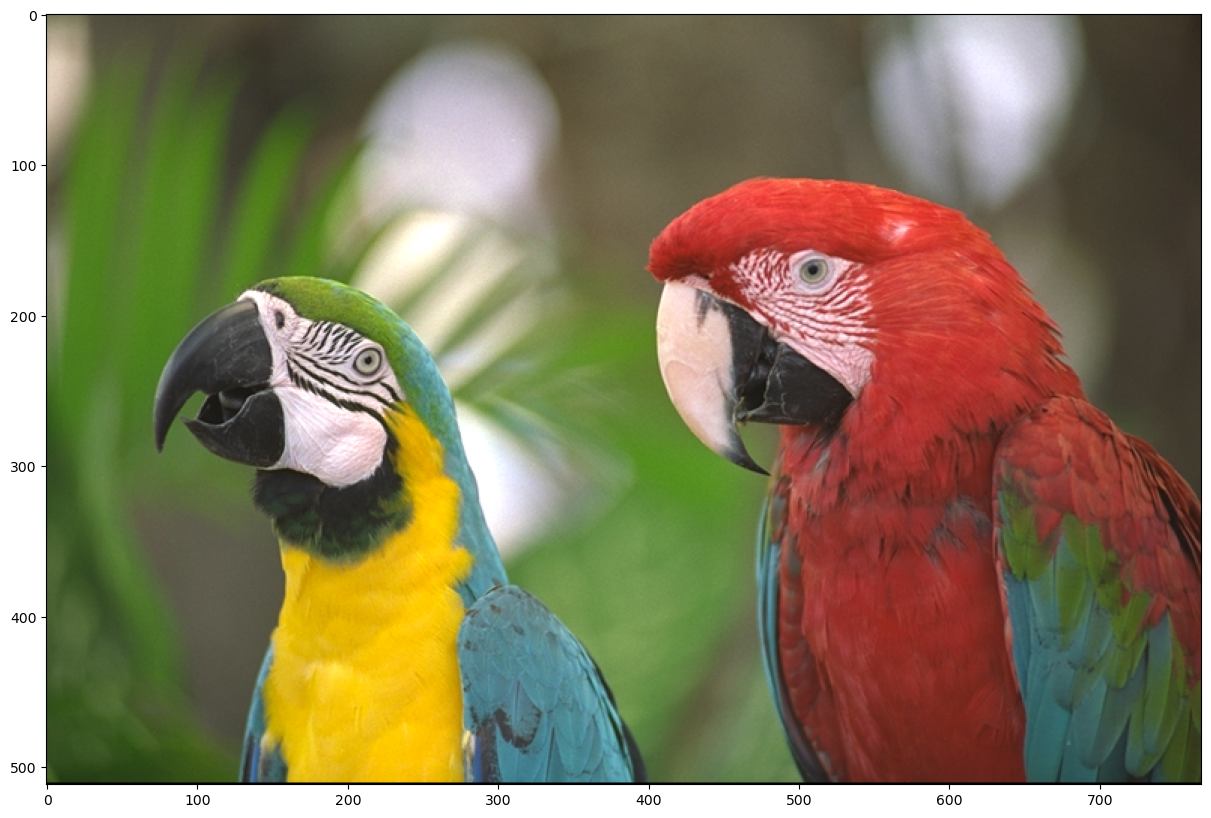

In [2]:
# Load image
img = cv2.imread('kodim23.png')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Plot it
plt.imshow(img)

Let's start with gray tones first.

In [42]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [255, 255, 255]])

In [3]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [64, 64, 64],
                   [192, 192, 192],
                   [255, 255, 255]])

Using the colour pallette, let's quantize the original image.

In [43]:
def find_closest_color(pixel, colors):
    # Calculate the Euclidean distance from the pixel to each color in the palette
    distances = np.sqrt(np.sum((colors - pixel) ** 2, axis=1))
    # Find the index of the closest color
    closest_color_index = np.argmin(distances)
    # Return the closest color
    return colors[closest_color_index]

In [44]:
# Cast the image to float
img = img.astype(float)

# Prepare for quantization
rows, cols, channels = img.shape
quantized = np.zeros_like(img)

# Apply quantization
for r in range(rows):
    for c in range(cols):
        # Extract the original pixel value
        pixel = img[r,c]
        
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        new_pixel =  find_closest_color(pixel, colors)
        
        # Apply quantization
        quantized[r, c, :] = new_pixel

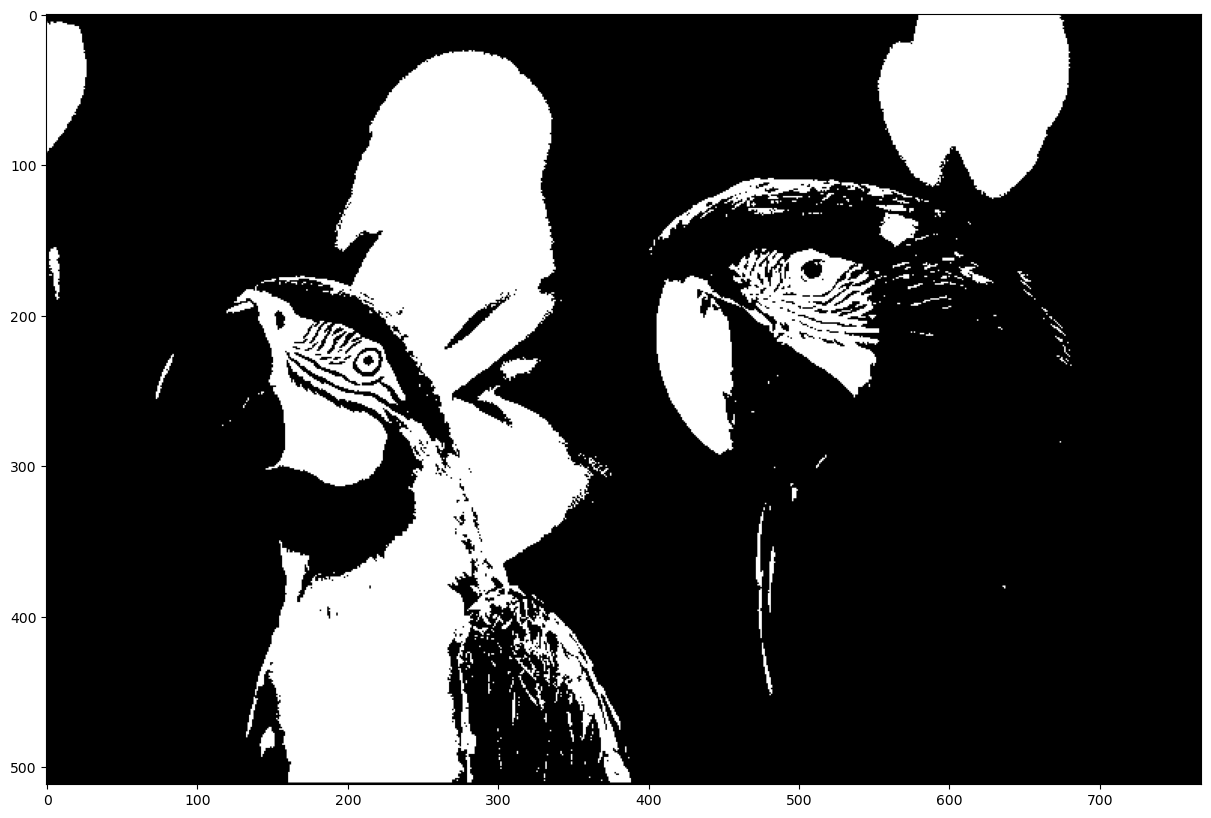

In [45]:
# Show quantized image (don't forget to cast back to uint8)
quantized = quantized.astype('uint8')
plt.imshow(quantized)

In [46]:
def psnr(ref, target):
    error = ref.astype(np.float32) - target.astype(np.float32)
    mse = np.mean(error**2)
    return 10 * np.log10((255**2)/mse)

In [47]:
# Compute average quantization error
avg_quant_error = psnr(img.astype('uint8'), quantized)

In [49]:
print(avg_quant_error)

8.787833619841734


#### Floyd-Steinberg Dithering
We are now going to implement the FS dithering and compare it to the optimally quantized image we have calculated above.

In [50]:
# Make a temporal copy of the original image, we will need it for error diffusion
img_tmp = np.copy(img)
dithering = np.zeros_like(img)

for r in range(1, rows-1):
    for c in range(1, cols-1):
        # Extract the original pixel value
        pixel = img[r,c] 
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        new_pixel = find_closest_color(pixel, colors)
        
        quant_error = pixel - new_pixel
        
        # Оновлюємо і кліпаємо тільки ті пікселі, до яких застосовуємо помилку
        if c + 1 < cols:
            img_tmp[r, c + 1] = np.clip(img_tmp[r, c + 1] + quant_error * 7 / 16, 0, 255)
        if r + 1 < rows and c - 1 >= 0:
            img_tmp[r + 1, c - 1] = np.clip(img_tmp[r + 1, c - 1] + quant_error * 3 / 16, 0, 255)
        if r + 1 < rows:
            img_tmp[r + 1, c] = np.clip(img_tmp[r + 1, c] + quant_error * 5 / 16, 0, 255)
        if r + 1 < rows and c + 1 < cols:
            img_tmp[r + 1, c + 1] = np.clip(img_tmp[r + 1, c + 1] + quant_error * 1 / 16, 0, 255)

        dithering[r, c] = new_pixel

(<Axes: >, <matplotlib.image.AxesImage at 0x1ad8ac62410>)

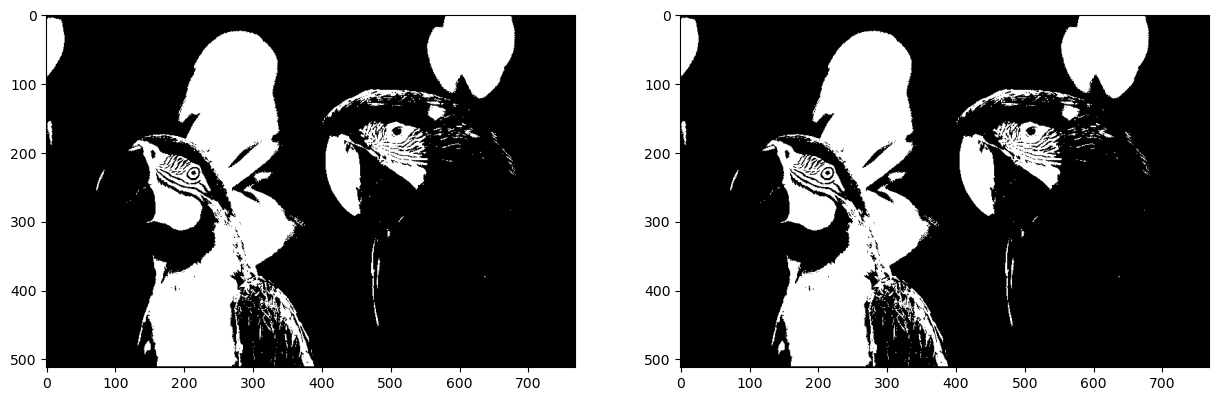

In [52]:
dithering = dithering.astype('uint8')
# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(quantized)   # optimally quantized
plt.subplot(122), plt.imshow(dithering)   # dithering

In [53]:
# Compute average quantization error for dithered image
avg_dith_error = psnr(img.astype('uint8'), dithering)

In [54]:
avg_dith_error

8.781916027209391

In [55]:
avg_quant_error - avg_dith_error

0.005917592632343371

### Questions
* Which image has higher quantization error? Optimally quantized or dithered?
* Which image looks better to you?
* Can you repeat the same process using only two colours: black and white? Show me :-)

1) Optimally quantized
2) Dithered, but not much better 
3) Repeated with black and white

### Bonus Points

Repeat the homework using a diffrerent image pallette. For instance, you can use an optimal colour
pallette that we can calculate via k-means algorithm. The following snippet of code will give you the 16
optimal colours for your original image.

In [87]:
%%time
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=256).fit(np.reshape(img, (-1, 3)))
colors = kmeans.cluster_centers_

D:\program\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


CPU times: total: 7min 27s
Wall time: 3min 7s


In [89]:
# Prepare for quantization
rows, cols, channels = img.shape
quantized = np.zeros_like(img)

# Apply quantization
for r in range(rows):
    for c in range(cols):
        # Extract the original pixel value
        pixel = img[r,c]
        
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        new_pixel =  find_closest_color(pixel, colors)
        
        # Apply quantization
        quantized[r, c, :] = new_pixel

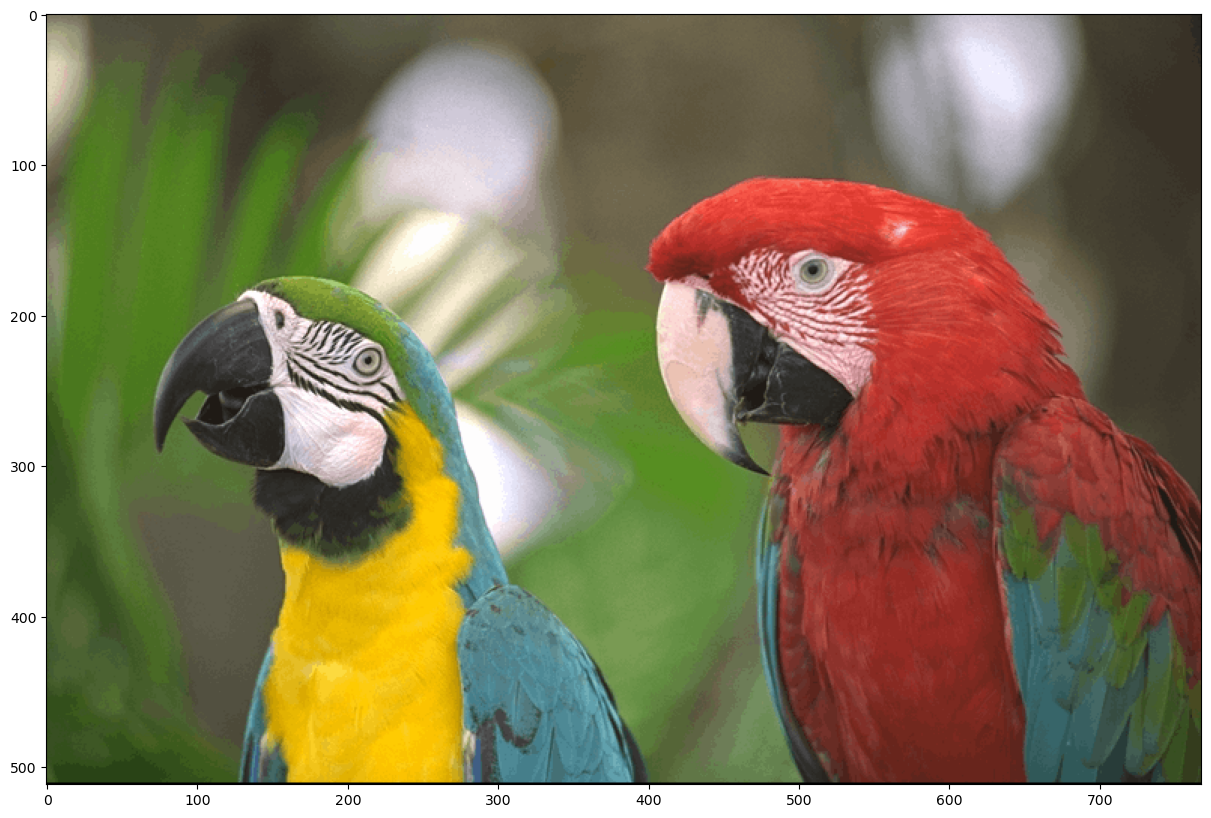

In [90]:
quantized = quantized.astype('uint8')
plt.imshow(quantized)

In [91]:
# Compute average quantization error
avg_quant_error = psnr(img.astype('uint8'), quantized)

In [92]:
print(avg_quant_error)

36.648410287163955


In [93]:
img_tmp = np.copy(img)
dithering = np.zeros_like(img)

for r in range(1, rows-1):
    for c in range(1, cols-1):
        # Extract the original pixel value
        pixel = img[r,c] 
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        new_pixel = find_closest_color(pixel, colors)
        
        quant_error = pixel - new_pixel
        
        # Оновлюємо і кліпаємо тільки ті пікселі, до яких застосовуємо помилку
        if c + 1 < cols:
            img_tmp[r, c + 1] = np.clip(img_tmp[r, c + 1] + quant_error * 7 / 16, 0, 255)
        if r + 1 < rows and c - 1 >= 0:
            img_tmp[r + 1, c - 1] = np.clip(img_tmp[r + 1, c - 1] + quant_error * 3 / 16, 0, 255)
        if r + 1 < rows:
            img_tmp[r + 1, c] = np.clip(img_tmp[r + 1, c] + quant_error * 5 / 16, 0, 255)
        if r + 1 < rows and c + 1 < cols:
            img_tmp[r + 1, c + 1] = np.clip(img_tmp[r + 1, c + 1] + quant_error * 1 / 16, 0, 255)

        dithering[r, c] = new_pixel

(<Axes: >, <matplotlib.image.AxesImage at 0x1ad8ba591d0>)

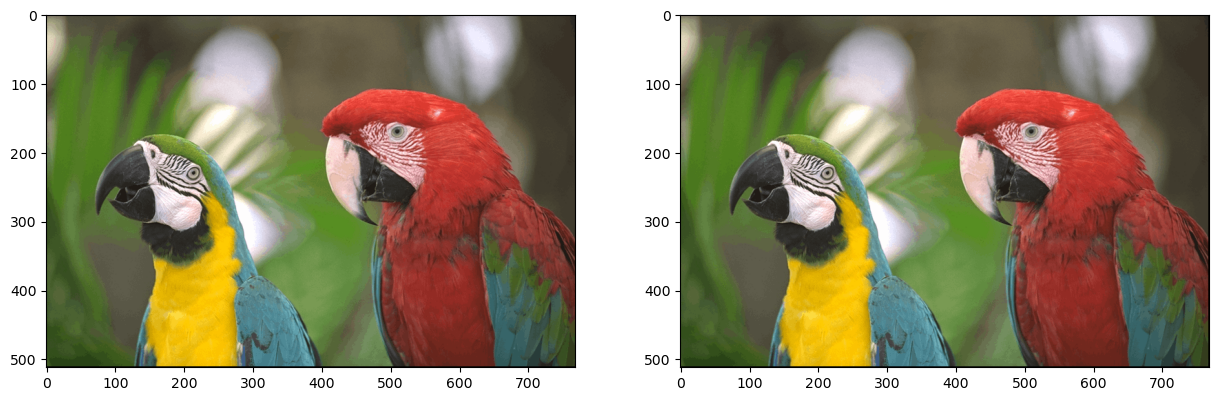

In [94]:
dithering = dithering.astype('uint8')
# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(quantized)   # optimally quantized
plt.subplot(122), plt.imshow(dithering)   # dithering

In [95]:
avg_dith_error = psnr(img.astype('uint8'), dithering)

In [96]:
print(avg_dith_error)

30.95204082032663


(<Axes: >, <matplotlib.image.AxesImage at 0x1ad89416b10>)

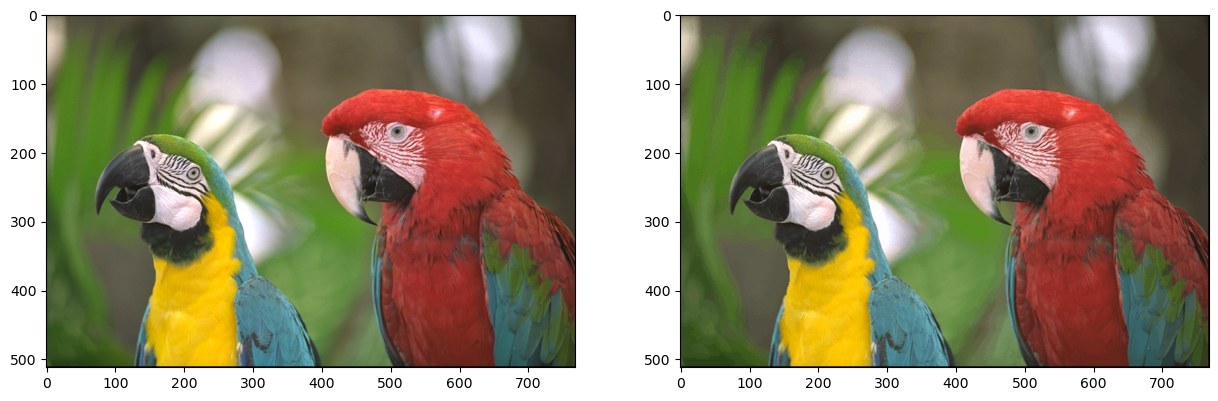

In [97]:
plt.subplot(121), plt.imshow(img.astype('uint8'))   # optimally quantized
plt.subplot(122), plt.imshow(dithering)   # dithering

Apply FS dithering the same way you did before.
* How does the result look like to you?
* What happens if we use 32 colours?
* And what happens if we use 256 colours?

1) I think it looks better than when we set the colors manually
2) Looks better and increases the difference between quantization and antialiasing errors
3) Looks great, but computes too slowly